# Demo PDF refinement with BVS restraint

In this example we setup a refinement of NaCl structure to experimental X-ray PDF.  The structure model will be also restrained by agreement of bond-valence sums with the expected atom valences.

In [1]:
# Initialize plotting within notebook.
%matplotlib inline

from matplotlib.pyplot import *
rc('figure', figsize=(8, 6))

# DiffPy-CMI functions for loading data and building a fitting recipe
from diffpy.Structure import loadStructure
from diffpy.srfit.pdf import PDFContribution
from diffpy.srfit.structure import constrainAsSpaceGroup
from diffpy.srfit.fitbase import FitRecipe, FitResults

# A least squares fitting algorithm from scipy
from scipy.optimize import leastsq

In [2]:
# Files containing our experimental data and structure file
dataFile = "NaCl.gr"
structureFile = "NaCl.cif"
spaceGroup = "F m -3 m"

In [3]:
# The first thing to construct is a contribution object which associates
# observed data and numerical model.  PDFContribution is a specialized
# contribution designed for PDF refinement of structure models.
# Here we create a new PDFContribution named "cpdf".
cpdf = PDFContribution("cpdf")

In [4]:
# Load the PDF data and set the r-range over which we'll fit.
cpdf.loadData(dataFile)
cpdf.setCalculationRange(xmin=1, xmax=30, dx=0.02)

In [5]:
# Add a structure model that will be used for PDF calculation.
nacl = loadStructure(structureFile)
cpdf.addStructure("nacl", nacl);

In [6]:
# Now cpdf.nacl now handles parameters for PDF calculation.
# cpdf.nacl.phase contains parameters relevant for the structure model.
# We can use the srfit function constrainAsSpaceGroup to constrain
# the lattice and ADP according to the relevant space group.
sgpars = constrainAsSpaceGroup(cpdf.nacl.phase, spaceGroup)
print("Space group parameters are " + ", ".join(p.name for p in sgpars) + ".")

Space group parameters are a, U11_0, U11_4.


In [7]:
# cpdf.nacl.phase also provides a restrainBVS function, which defines
# a soft restraint for agreement between the expected and calculated valences.
# restrainBVS returns the active Restraint object.  We save it so we can
# later manipulate its weight in the cost function.
rbv = cpdf.nacl.phase.restrainBVS()

In [8]:
# The FitRecipe does the work of managing refined variables and calculating
# residuals from all contributions and restraints.
thefit = FitRecipe()
# Turn off printing of iteration number.
thefit.clearFitHooks()

# We give our PDF model to the fit to be optimized.
thefit.addContribution(cpdf)

In [9]:
# We now link various model parameters to the fit variables that
# will be refined.  We will start with PDF scale, resolution damping
# factor qdamp and the peak sharpening coefficient delta2.
thefit.addVar(cpdf.scale, value=1)
thefit.addVar(cpdf.qdamp, value=0.03)
thefit.addVar(cpdf.nacl.delta2, value=5)

# We will also refine independent structure parameters that were found
# for our space group and atom coordinates.
for par in sgpars.latpars:
    thefit.addVar(par)
# Here we set the initial value for the anisotropic displacement
# parameters, because CIF had no ADP data.
for par in sgpars.adppars:
    thefit.addVar(par, value=0.005)
# Position parameters can be also constrained.  This does nothing
# for NaCl, because all atoms are at a special positions.
for par in sgpars.xyzpars:
    thefit.addVar(par)

In [10]:
# We can now execute the fit using scipy's least square optimizer.
# Let's define a few functions so it is easier to rerun the fit later.

def namesandvalues():
    "Format names and values of the active fit variables."
    return ' '.join("%s=%g" % nv for nv in zip(thefit.names, thefit.values))

def chattyfit():
    print("Refine PDF using scipy's least-squares optimizer:")
    print("  initial: " + namesandvalues())
    rv = leastsq(thefit.residual, thefit.values)
    print("  final: " +  namesandvalues())
    print('')
    return rv

def plotthefit():
    # Get the experimental data from the recipe
    r = thefit.cpdf.profile.x
    gobs = thefit.cpdf.profile.y
    gcalc = thefit.cpdf.evaluate()
    baseline = 1.1 * gobs.min()
    gdiff = gobs - gcalc
    figure()
    plot(r, gobs, 'bo', label="G(r) data",
        markerfacecolor='none', markeredgecolor='b')
    plot(r, gcalc, 'r-', label="G(r) fit")
    plot(r, gdiff + baseline, 'g-', label="G(r) diff")
    plot(r, 0.0 * r + baseline, 'k:')
    xlim(0, 30)
    xlabel(u"r (Å)")
    ylabel(u"G (Å$^{-2}$)")
    legend()
    return

Refine PDF using scipy's least-squares optimizer:
  initial: scale=1 qdamp=0.03 delta2=5 a=5.62 U11_0=0.005 U11_4=0.005
  final: scale=0.178415 qdamp=0.0602221 delta2=3.60688 a=5.60112 U11_0=0.0124785 U11_4=0.00800028



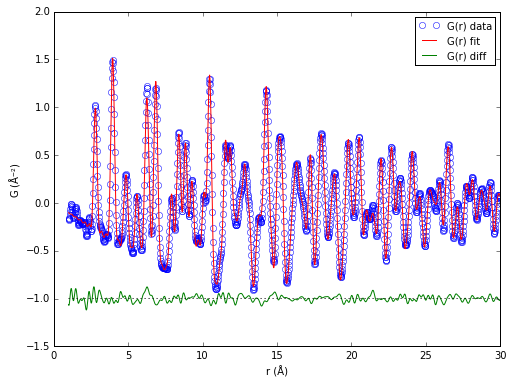

In [11]:
# Perform the fit and plot it now.
chattyfit();
plotthefit();

In [12]:
# Report fit results:
results = FitResults(thefit)
print(results)

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
-------------------------------------------------------------------------------
Residual       1.74963573
Contributions  1.74805031
Restraints     0.00158543
Chi2           1.74805031
Reduced Chi2   0.00120889
Rw             0.08354829

Variables (Uncertainties invalid)
-------------------------------------------------------------------------------
U11_0   1.24785485e-02 +/- 3.77067868e-03
U11_4   8.00027624e-03 +/- 1.62768098e-03
a       5.60112351e+00 +/- 3.57708693e-03
delta2  3.60688253e+00 +/- 2.65484894e+00
qdamp   6.02221123e-02 +/- 6.14364688e-03
scale   1.78415235e-01 +/- 2.00386412e-02

Variable Correlations greater than 25% (Correlations invalid)
-------------------------------------------------------------------------------
corr(scale, qdamp)    0.5747
corr(qdamp, delta2)   -0.3777
corr(scale, U11_4)    0.3113
corr(delta2, U11_0)   0.3043



## Explore convergence of the BVS-restrained fit

Let's try to run fit with a far-off value of the lattice parameter.

Refine PDF using scipy's least-squares optimizer:
  initial: scale=0.178415 a=4
  final: scale=0.0239558 a=3.97884



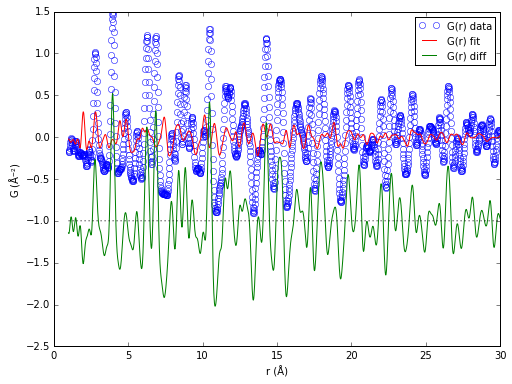

In [13]:
thefit.fix('delta2', 'U11_0', 'U11_4', 'qdamp')
thefit.a = 4
chattyfit()
plotthefit()

The fit looks terrible, however it has still converged to a local minimum.  Note the second peak in the simulated PDF lines up with the first peak in the data.  To move out of the local minimum, we need to increase the weight of the BVS restraint *rvb*.  This can be done by adjusting its *sig* attribute, which provides a scale for the difference in valences.  The penalty contribution due to BVS is $[(V_{exp} - V_{sim}) / sig]^2$.

Refine PDF using scipy's least-squares optimizer:
  initial: scale=0.0239558 a=3.97884
  final: scale=0.178418 a=5.60119



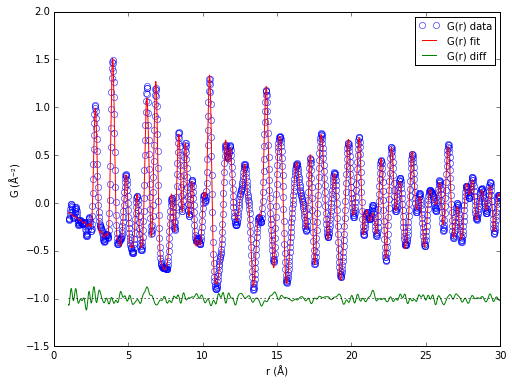

In [14]:
# Increase weight of the BVS restraint and refine again
rbv.sig = 0.1
chattyfit()
plotthefit()

## Explore effect of restraint weight on the lattice parameter

We will run the refinement at different values of the restraint parameter sig to explore where does it overweight the lattice parameter refined from PDF.

In [15]:
import numpy
sigvalues = numpy.logspace(-4, 0)
avalues = []
for rbv.sig in sigvalues:
    leastsq(thefit.residual, thefit.values)
    avalues.append(thefit.a.value)

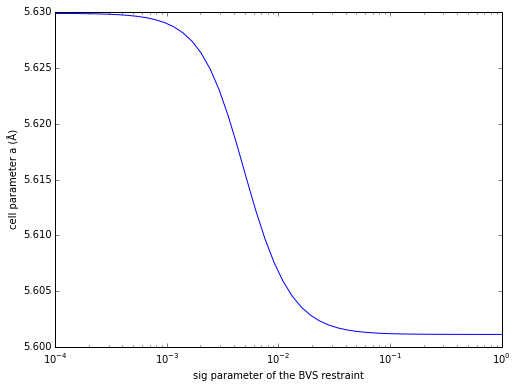

In [16]:
semilogx(sigvalues, avalues)
xlabel('sig parameter of the BVS restraint')
ylabel(u'cell parameter a (Å)');

A more tight restraint at *rvb.sig = 0.1* allowed the refinement to escape a far-off local minimum and recover the original fit.  The restraint is however still at the PDF-dominant region, so there is no significant change of the refined cell parameter.